In [1]:
import os
import numpy as np
from math import sqrt
from scipy import stats
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric import data as DATA
from torch_geometric.loader import DataLoader
import os
import pandas as pd
import numpy as np
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

import os
import os.path as osp
import re

import torch
from torch_geometric.data import (InMemoryDataset, Data, download_url,
                                  extract_gz)

try:
    from rdkit import Chem
except ImportError:
    Chem = None


RDKit WARNING: [15:24:14] Enabling RDKit 2019.09.3 jupyter extensions
[15:24:14] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
def smiles_features(mol):
    symbols = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',    #list of all elements in the dataset
        'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce', 
        'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al', 
        'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn', 
        'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd', 
        'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C',
        'Re','Ta','Ir','Be','Tl']

    hybridizations = [
        Chem.rdchem.HybridizationType.S,
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2,
        'other',
    ]

    stereos = [
        Chem.rdchem.BondStereo.STEREONONE,
        Chem.rdchem.BondStereo.STEREOANY,
        Chem.rdchem.BondStereo.STEREOZ,
        Chem.rdchem.BondStereo.STEREOE,
    ]
    features = []
    xs = []
    for atom in mol.GetAtoms():
        symbol = [0.] * len(symbols)
        symbol[symbols.index(atom.GetSymbol())] = 1.
        #comment degree from 6 to 8
        degree = [0.] * 8
        degree[atom.GetDegree()] = 1.
        formal_charge = atom.GetFormalCharge()
        radical_electrons = atom.GetNumRadicalElectrons()
        hybridization = [0.] * len(hybridizations)
        hybridization[hybridizations.index(
            atom.GetHybridization())] = 1.
        aromaticity = 1. if atom.GetIsAromatic() else 0.
        hydrogens = [0.] * 5
        hydrogens[atom.GetTotalNumHs()] = 1.
        chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
        chirality_type = [0.] * 2
        if atom.HasProp('_CIPCode'):
            chirality_type[['R', 'S'].index(atom.GetProp('_CIPCode'))] = 1.
    
        x = torch.tensor(symbol + degree + [formal_charge] +
                         [radical_electrons] + hybridization +
                         [aromaticity] + hydrogens + [chirality] +
                         chirality_type)
        xs.append(x)
    
        x = torch.stack(xs, dim=0)

    edge_indices = []
    edge_attrs = []
    for bond in mol.GetBonds():
        edge_indices += [[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]]
        edge_indices += [[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]]
    
        bond_type = bond.GetBondType()
        single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
        double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
        triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
        aromatic = 1. if bond_type == Chem.rdchem.BondType.AROMATIC else 0.
        conjugation = 1. if bond.GetIsConjugated() else 0.
        ring = 1. if bond.IsInRing() else 0.
        stereo = [0.] * 4
        stereo[stereos.index(bond.GetStereo())] = 1.
    
        edge_attr = torch.tensor(
            [single, double, triple, aromatic, conjugation, ring] + stereo)
    
        edge_attrs += [edge_attr, edge_attr]
    
    if len(edge_attrs) == 0:
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0, 10), dtype=torch.float)
    else:
        edge_index = torch.tensor(edge_indices).t().contiguous()
        edge_attr = torch.stack(edge_attrs, dim=0)
    return x, edge_index, edge_attr

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    if mol == None:
        return None
    
    c_size = mol.GetNumAtoms()
    features, edge_index, edge_attr = smiles_features(mol)
        
    return features, edge_index, edge_attr

In [3]:
class Molecule_data(InMemoryDataset):
    def __init__(self, root='/tmp', dataset='_drug1',xd=None, xt=None, y=None, xt_featrue=None, transform=None,
                 pre_transform=None,smile_graph=None):

        #root is required for save preprocessed data, default is '/tmp'
        super(Molecule_data, self).__init__(root, transform, pre_transform)
        self.dataset = dataset
        if os.path.isfile(self.processed_paths[0]):
#             print('Pre-processed data found: {}, loading ...'.format(self.processed_paths[0]))
            self.data, self.slices = torch.load(self.processed_paths[0])
        else:
            print('Pre-processed data {} not found, doing pre-processing...'.format(self.processed_paths[0]))
            self.process(xd, xt, xt_featrue, y, smile_graph)
            self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        pass
        #return ['some_file_1', 'some_file_2', ...]

    @property
    def processed_file_names(self):
        return [self.dataset + '.pt']

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def _download(self):
        pass

    def _process(self):
        if not os.path.exists(self.processed_dir):
            os.makedirs(self.processed_dir)
            
    def get_cell_feature(self, cellId, cell_features):
        for row in islice(cell_features, 0, None):
            if cellId in row[0]:
                return row[1:]
        return False

    def process(self, xd, xt, xt_featrue,y,smile_graph):
        assert (len(xd) == len(xt) and len(xt) == len(y)), "The three lists must be the same length!"
        data_list = []
        data_len = len(xd)
        for i in range(data_len):
            print('Converting SMILES to graph: {}/{}'.format(i+1, data_len))
            smiles = xd[i]
            target = xt[i]
            labels = y[i]
            # convert SMILES to molecular representation using rdkit
            x, edge_index, edge_attr = smile_graph[smiles]
            # make the graph ready for PyTorch Geometrics GCN algorithms:
            GCNData = Data(x=torch.Tensor(x),
                      edge_index=edge_index,
                      edge_attr=edge_attr,
                      y=torch.FloatTensor([labels]))
        
            cell = self.get_cell_feature(target, xt_featrue)

            if cell == False : 
                print('cell', cell)
                sys.exit()

            new_cell = []
            # print('cell_feature', cell_feature)
            for n in cell:
                new_cell.append(float(n))
            GCNData.cell = torch.FloatTensor([new_cell])
            # append graph, label and target sequence to data list
            data_list.append(GCNData)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        print('Graph construction done. Saving to file.')
        data, slices = self.collate(data_list)
#         print(data.shape,slices.shape)
        # save preprocessed data:
        torch.save((data, slices), self.processed_paths[0])

In [4]:
import csv
from itertools import islice

import pandas as pd
import numpy as np
import os
import json, pickle
from collections import OrderedDict
from rdkit import Chem
import networkx as nx


def creat_data(datafile, cellfile):
    file2 = cellfile
    cell_features = []
    with open(file2) as csvfile:
        csv_reader = csv.reader(csvfile)  
        for row in csv_reader:
            cell_features.append(row)
    cell_features = np.array(cell_features)
    print('cell_features', cell_features)

    compound_iso_smiles = []
    df = pd.read_csv('/media/4TB_hardisk/waleed/graph/New_Expriment/data/smiles.csv')
    compound_iso_smiles += list(df['smile'])
    compound_iso_smiles = set(compound_iso_smiles)
    smile_graph = {}
    for smile in compound_iso_smiles:
        g = smile_to_graph(smile)
        smile_graph[smile] = g

    datasets = datafile
    # convert to PyTorch data format
    processed_data_file_train = 'data_perparation/processed/' + datasets + '_train.pt'

    if ((not os.path.isfile(processed_data_file_train))):
        df = pd.read_csv('/media/4TB_hardisk/waleed/graph/New_Expriment/data/' + datasets + '.csv')
        drug1, drug2, cell, label = list(df['drug1']), list(df['drug2']), list(df['cell']), list(df['label'])
        drug1, drug2, cell, label = np.asarray(drug1), np.asarray(drug2), np.asarray(cell), np.asarray(label)
        # make data PyTorch Geometric ready

        Molecule_data(root='data_perparation', dataset=datafile + '_drug1', xd=drug1, xt=cell, xt_featrue=cell_features, y=label,smile_graph=smile_graph)
        Molecule_data(root='data_perparation', dataset=datafile + '_drug2', xd=drug2, xt=cell, xt_featrue=cell_features, y=label,smile_graph=smile_graph)
        print('preparing ', datasets + '_.pt in pytorch format!')

if __name__ == "__main__":
    cellfile = '/media/4TB_hardisk/waleed/graph/New_Expriment/data/new_cell_features_954.csv'
    da = ['new_labels_0_10']
    for datafile in da:
        creat_data(datafile, cellfile)

cell_features [['gene_id' 'ENSG00000116237' 'ENSG00000162413' ... 'ENSG00000157617'
  'ENSG00000160208' 'ENSG00000141959']
 ['transcript_id' 'ENST00000343813' 'ENST00000377658' ...
  'ENST00000329623' 'ENST00000340648' 'ENST00000349048']
 ['A2058' '51.07' '20.76' ... '1.46' '23.67' '78.86']
 ...
 ['YKG1_CENTRAL_NERVOUS_SYSTEM' '41.25' '23.28' ... '1.72' '18.24'
  '71.48']
 ['ZR751_BREAST' '30.69' '4.72' ... '0.77' '6.8' '36.37']
 ['ZR7530_BREAST' '25.04' '7.31' ... '5.44' '10.06' '73.45']]
preparing  new_labels_0_10_.pt in pytorch format!


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GATConv,TransformerConv
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import max_pool as mxp
from torch_geometric.nn import avg_pool as agp
import pandas as pd
import numpy as np




# GTN  model
class TransfGNN1(torch.nn.Module):
    def __init__(self, num_features_xd=92, n_output=2, num_features_xt=954, output_dim=128, dropout=0.2, file=None):
        super(TransfGNN1, self).__init__()

        # graph drug layers
        self.drug1_gcn1 = TransformerConv(num_features_xd, output_dim, heads=20,edge_dim=10, dropout=dropout)
        self.drug1_gcn2 = TransformerConv(output_dim *20, output_dim,edge_dim=10, dropout=dropout)
        # self.drug1_gcn3 = GATConv(output_dim, output_dim, dropout=dropout)
        self.drug1_fc_g1 = nn.Linear(output_dim, output_dim)
        # self.drug1_fc_g2 = nn.Linear(2048, output_dim)
        self.filename = file


        # DL cell featrues
        self.reduction = nn.Sequential(
            nn.Linear(num_features_xt, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_dim * 2),
            nn.ReLU()
        )


        # combined layers
        self.fc1 = nn.Linear(output_dim * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        #self.fc3 = nn.Linear(256, 128)
        self.out = nn.Linear(128, n_output)

        # activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.output_dim = output_dim

    def get_col_index(self, x):
        row_size = len(x[:, 0])
        row = np.zeros(row_size)
        col_size = len(x[0, :])
        for i in range(col_size):
            row[np.argmax(x[:, i])] += 1
        return row

    def save_num(self, d, path):
        d = d.cpu().numpy()
        ind = self.get_col_index(d)
        ind = pd.DataFrame(ind)
        ind.to_csv('data/case_study/' + path + '_index.csv', header=0, index=0)

    def forward(self, data1, data2):
        x1, edge_index1,edge_attr1, batch1, cell = data1.x.float(), data1.edge_index,data1.edge_attr, data1.batch, data1.cell
        
        x2, edge_index2,edge_attr2, batch2 = data2.x.float(), data2.edge_index,data2.edge_attr, data2.batch
        # deal drug1
        x1 = self.drug1_gcn1(x1, edge_index=edge_index1,edge_attr=edge_attr1)
        x1 = F.relu(x1)
        #x1 = F.dropout(x1, p=0.1, training=self.training)
        x1 = self.drug1_gcn2(x1, edge_index=edge_index1,edge_attr=edge_attr1)
        x1 = F.relu(x1)
        #x1 = F.dropout(x1, p=0.1, training=self.training)
    
        x1 = gmp(x1,batch1)         # global max pooling


        x1 = self.drug1_fc_g1(x1)
        x1 = self.relu(x1)
        # x1 = self.drug1_fc_g2(x1)
        # x1 = self.relu(x1)

        # deal drug2
    
        x2 = self.drug1_gcn1(x2, edge_index2,edge_attr=edge_attr2)
        x2 = F.relu(x2)
        #x2 = F.dropout(x2, p=0.1, training=self.training)
        x2 = self.drug1_gcn2(x2, edge_index2,edge_attr=edge_attr2)
        x2 = F.relu(x2)
        #x2 = F.dropout(x2, p=0.1, training=self.training)
    



        x2 = gmp(x2,batch2)  # global max pooling


        x2 = self.drug1_fc_g1(x2)
        x2 = self.relu(x2)
        # x2 = self.drug1_fc_g2(x2)
        # x2 = self.relu(x2)

        # deal cell
        cell = F.normalize(cell, 2, 1)
        cell_vector = self.reduction(cell)



        # concat
        xc = torch.cat((x1, x2, cell_vector), 1)
        xc = F.normalize(xc, 2, 1)
        # add some dense layers
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        #xc = self.dropout(xc)
        #xc = self.fc3(xc)
        #xc = self.relu(xc)
        #xc = self.dropout(xc)
        out = self.out(xc)
        return out


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from scipy import interp
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix,recall_score,matthews_corrcoef,roc_curve,roc_auc_score,auc,precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, accuracy_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import math
from random import shuffle

def analyze(temp, OutputDir):
    file = open(OutputDir + '/performance.txt', 'w')
    testing_result = temp
    index = 0


    for x in [testing_result]:


        title = ''

        if index == 0:
            title = 'testing_'

        index += 1

        file.write(title +  'results\n')


        for j in ['sn', 'sp', 'acc','bacc', 'MCC','AUC', 'precision','F1','kappa']: #,'pre_recall_curve'

            total = []

            for val in x:
                total.append(val[j])
            file.write(j + ' : mean : ' + str(np.mean(total)) + ' std : ' + str(np.std(total))  + '\n')

        file.write('\n\n______________________________\n')


    index = 0


    for x in [testing_result]:
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        i = 0

        for val in x:
            tpr = val['tpr']
            fpr = val['fpr']
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.3f)' % (i+1, roc_auc))

            i += 1

        #plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        #mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')


        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic curve')
        plt.legend(loc="lower right")

        title = ''

        if index == 0:
            title = 'testing_'
        

        plt.savefig( OutputDir+ '/' +title +'ROC.png')
        plt.close('all')

       #************************** Precision Recall Curve*********************************
        i = 0
        prs = []
        pre_aucs = []
        mean_recal= np.linspace(0, 1, 100)
        for val in x:
            pre = val['prec']
            rec = val['reca']
            prs.append(interp(mean_recal, rec, pre))
            #prs[-1][0] = 0.0
            p_r_auc = auc(rec, pre)
            pre_aucs.append(p_r_auc)
            plt.plot(rec, pre, lw=1, alpha=0.3,label='PRC fold %d (AUC = %0.3f)' % (i+1, p_r_auc))

            i += 1

        #plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)

        mean_pre = np.mean(prs, axis=0)
        #mean_pre[-1] = 0.0
        mean_auc = auc(mean_recal, mean_pre)
        std_auc = np.std(pre_aucs)
        plt.plot(mean_recal, mean_pre, color='b',
                 label=r'Mean PRC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)


        std_pre = np.std(prs, axis=0)
        pre_upper = np.minimum(mean_pre + std_pre, 1)
        pre_lower = np.maximum(mean_pre - std_pre, 0)
        plt.fill_between(mean_recal, pre_lower, pre_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall curve')
        plt.legend(loc="lower right")

        title = ''

        if index == 0:
            title = 'testing_'
    

        plt.savefig( OutputDir + '/'+ title +'Pre_R_C.png')
        plt.close('all');


        index += 1

    file.close()
    
def calculateScore(y,pred_y):
    tn = 0
    fn = 0
    tp = 0
    fp = 0
     
    ROCArea = roc_auc_score(y, pred_y)
    fpr, tpr, thresholds = roc_curve(y, pred_y)
    lossValue = None;
    
    pre, rec, threshlds = precision_recall_curve(y, pred_y)
    pre = np.fliplr([pre])[0]  #so the array is increasing (you won't get negative AUC)
    rec = np.fliplr([rec])[0]  
    AUC_prec_rec = np.trapz(rec,pre)
    AUC_prec_rec = abs(AUC_prec_rec)
    
    pred_y[pred_y > 0.5] = 1
    pred_y[~(pred_y > 0.5)] = 0
    
    label = np.column_stack((y, pred_y))
    for i in range(len(label)):
        if label[i][0] == 0:
            if label[i][1] == 0:
                tn = tn + 1
            else:
                fp = fp + 1
        else:
            if label[i][1] == 0:
                fn = fn + 1
            else:
                tp = tp + 1

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    MCC = ((tp * tn) - (fp * fn)) / math.sqrt((tp + fn) * (tp + fp) * (tn + fn) * (tn + fp))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1Score =  precision * recall * 2 / (precision + recall)
    BACC = balanced_accuracy_score(y, pred_y)
    KAPPA = cohen_kappa_score(T, Y)


    return {'sn' : sensitivity, 'sp' : specificity,'bacc':BACC ,'acc' : accuracy, 'MCC' : MCC,'kappa':KAPPA, 'AUC' : ROCArea,'precision' : precision, 'F1' : F1Score, 'fpr' : fpr, 'tpr' : tpr, 'thresholds' : thresholds,'pre_recall_curve':AUC_prec_rec,'prec':pre,'reca':rec}

In [7]:
import random
import numpy as np
import pandas as pd
import sys, os
from random import shuffle
import torch.utils.data as Data
import math
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import cohen_kappa_score, accuracy_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
def predicting(model, device, drug1_loader_test, drug2_loader_test):
    #model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    total_prelabels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(drug1_loader_test.dataset)))
    with torch.no_grad():
        for data in zip(drug1_loader_test, drug2_loader_test):
            data1 = data[0]
            data2 = data[1]
            data1 = data1.to(device)
            data2 = data2.to(device)
            output = model(data1, data2) #data.x.float(), data.edge_index,data.batch
            ys = F.softmax(output, 1).to('cpu').data.numpy()
            predicted_labels = list(map(lambda x: np.argmax(x), ys))
            predicted_scores = list(map(lambda x: x[1], ys))
            total_preds = torch.cat((total_preds, torch.Tensor(predicted_scores)), 0)
            total_prelabels = torch.cat((total_prelabels, torch.Tensor(predicted_labels)), 0)
            total_labels = torch.cat((total_labels, data1.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten(), total_prelabels.numpy().flatten()


# CPU or GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('The code uses GPU...')
else:
    device = torch.device('cpu')
    print('The code uses CPU!!!')

results = []
TEST_BATCH_SIZE = 128
testing_result = []

    
datafile = 'new_labels_0_10'
OutputDir='/media/4TB_hardisk/waleed/graph/New_Expriment/Model_Results/Results/'+datafile+'/'
ture_y = []
pred_y = []

for i in range(5):
    model = TransfGNN1().to(device)
    path = 'best_models/'+datafile+'/TransfGNN_model' + str(i) + '.model'
    model.load_state_dict(torch.load(path))
    drug1_data_test = torch.load('/media/4TB_hardisk/waleed/graph/New_Expriment/Model_Results/folds/Drug1/fold_'+str(i)+'1_'+'x_test.pt')
    drug1_loader_test = DataLoader(drug1_data_test, batch_size=TEST_BATCH_SIZE, shuffle=False)
    drug2_data_test = torch.load('/media/4TB_hardisk/waleed/graph/New_Expriment/Model_Results/folds/Drug2/fold_'+str(i)+'2_'+'x_test.pt')
    drug2_loader_test = DataLoader(drug2_data_test, batch_size=TEST_BATCH_SIZE, shuffle=False)
    T, S, Y = predicting(model, device, drug1_loader_test, drug2_loader_test)
    ture_y.append(T)
    pred_y.append(S)
    testing_result.append(calculateScore(T, S))
temp_dict = (testing_result)
analyze(temp_dict, OutputDir)

The code uses GPU...
Make prediction for 2483 samples...
Make prediction for 2483 samples...
Make prediction for 2483 samples...
Make prediction for 2483 samples...
Make prediction for 2483 samples...


/home/waleed/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/waleed/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


In [8]:
def plot_confusion_matrix(cm, classes,
                              normalize=True,
                              title='Confusion Matrix', fontsize=18,
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion Matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True Label',fontsize=12)
        plt.xlabel('Predicted Label',fontsize=12)
        plt.tight_layout()

In [9]:
true_y = [item for sublist in ture_y for item in sublist]
len(true_y)

12415

In [10]:
pred_y = [item for sublist in pred_y for item in sublist]

In [11]:
confusion = confusion_matrix(true_y,pred_y)

Normalized confusion matrix
[[0.91963151 0.08036849]
 [0.05311325 0.94688675]]


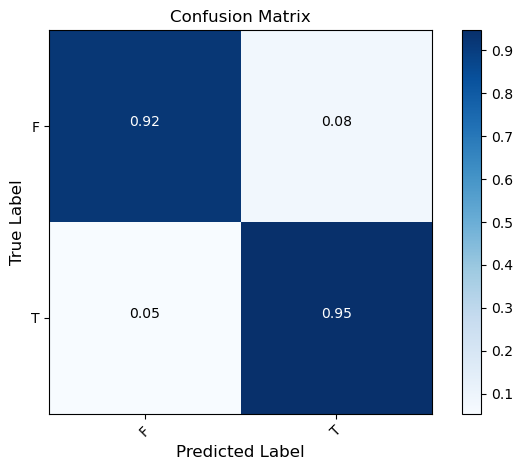

In [12]:
import itertools
plot_confusion_matrix(confusion,classes=['F','T'])
plt.savefig('random_split_CM.png')

In [13]:
# CPU or GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('The code uses GPU...')
else:
    device = torch.device('cpu')
    print('The code uses CPU!!!')
    
    
model = TransfGNN1().to(device)
path = 'best_models/'+datafile+'/TransfGNN_model' + str(1) + '.model'
model.load_state_dict(torch.load(path))
drug1_data_test = torch.load('/media/4TB_hardisk/waleed/graph/New_Expriment/Model_Results/folds/Drug1/fold_'+str(0)+'1_'+'x_test.pt')
drug1_loader_test = DataLoader(drug1_data_test, batch_size=9932, shuffle=False)
drug2_data_test = torch.load('/media/4TB_hardisk/waleed/graph/New_Expriment/Model_Results/folds/Drug2/fold_'+str(0)+'2_'+'x_test.pt')
drug2_loader_test = DataLoader(drug2_data_test, batch_size=9932, shuffle=False)    
    
output = []
with torch.no_grad():
        for data in zip(drug1_loader_test, drug2_loader_test):
            data1 = data[0]
            data2 = data[1]
            data1 = data1.to(device)
            data2 = data2.to(device)
            output.append(model(data1, data2))
feature = output[0]
feature = feature.cpu()
feature = feature.detach().numpy()

The code uses GPU...


In [14]:
from sklearn.manifold import TSNE
embedded=TSNE(n_components=2).fit_transform(feature)
label=[]
for x in drug1_loader_test:
    label.append(x.y)

/home/waleed/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/waleed/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


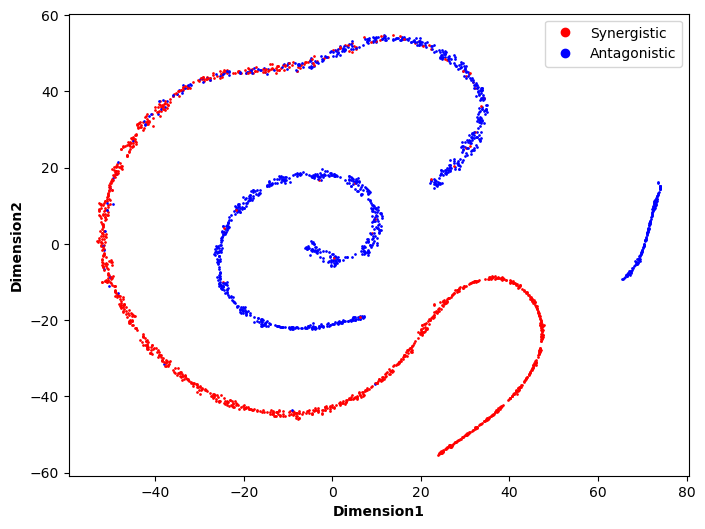

In [15]:
from matplotlib import pyplot as plt
capsul_feature=plt.figure(figsize=(8,6))
for i, labels in enumerate(label[0]):
    if int(labels)==0:
    #if int(np.argmax(labels))==0:
        plt.scatter(embedded[i,0],embedded[i,1],c='r',s=0.9,facecolors='none',label='Antagonistic')
    else:
        plt.scatter(embedded[i,0],embedded[i,1],c='b',s=0.9,facecolors='none',label='Synergistic')
plt.ylabel('Dimension2',fontweight='bold')
plt.xlabel('Dimension1',fontweight='bold')
l1=plt.Line2D(range(0),range(0),marker='o',color='r',linestyle='')
l2=plt.Line2D(range(0),range(0),marker='o',color='b',linestyle='')
plt.legend((l1,l2),('Synergistic','Antagonistic'),loc='upper right',numpoints=1)
capsul_feature.savefig('train_last_fold1.png') #for saving figure
plt.show()